In [ ]:
!pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import emcee

from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.integrate import simps

## MCMC Sampler

In [ ]:
def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):

    mnwalkers, mndim = x0.shape

    sampler = emcee.EnsembleSampler(mnwalkers,
                                    mndim,
                                    log_post)
    sampler.run_mcmc(x0, nburn, progress=True,tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    print('Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=True,tune=True)

    return sampler.get_log_prob(), sampler.get_chain()

def big_sampler(x,y,sigma_y,theoretical_waveform, theta0, log_prior=lambda _:0.0, nburn=300, steps=3000):
    def log_posterior(theta):
        res=np.abs(y-theoretical_waveform(x,theta))/sigma_y
        return -2*np.sum(res**2)/2 #+ log_prior(theta)

    ndim=len(theta0)
    nwalkers=8*ndim
    p0=np.zeros((nwalkers,ndim))
    for i in range(nwalkers):
        p0[i]=theta0*np.random.normal(loc=1.0, scale=0.001, size=ndim)

    return emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)

def my_priors(pars):
    if pars[0]<0: #or pars[1]<0 or pars[2]<0 or pars[2]>2*np.pi:
        return -np.inf
    return 0.

## Modeling Signals in the Frequency domain

In [ ]:
# a*t

def hFa(f,pars=np.array([1e-23])):
    a=pars[0]
    return -(1/dt)*a*np.exp(-2j*np.pi*f*T)*(np.exp(2j*np.pi*f*T)-1-2j*np.pi*f*T
    )/(2*np.pi*f)**2

## Generate Data using Two Atomic Clocks



1.   Determine the characteristics of your dataset e.g. number of years, sampling rate etc.
2.   Generate white and pink noise.
3. Define the power spectral density coefficients of your clock (white and pink noise).
4. Combine PSD of the noise from the two clocks and factor in the sensitivity coefficients according to the formula:
$$
\frac{\Delta R}{R} = \left( K_{X,1} - K_{X,2} \right)\frac{\Delta X}{X}
$$

5. Generate a signal to inject into the noise.
6. Add the signal to the noise to produce the dataset to be passed to the MCMC framework.



In [ ]:
''' Dataset Characteristics '''
########## input ###########
Ts=86400*365
nyr=3.01
T=Ts*nyr
dt=1
N=int(T/dt)

''' Frequency discretization '''

freqs = fftfreq(N, dt)[0:N//2]
fredd=freqs[freqs<5e-6]
fred=fredd[1:]

''' Noise generation '''

# Clock 1  ########## input ###########
h0a=3e-33
hm1a=7.2e-37
K1=0.

# Clock 2  ########## input ###########
h0b=8e-28  ##
hm1b=2.8e-32 ##
K2=1.  ##

# Combination

h0=h0a+h0b
hm1=hm1a+hm1b
Ktot=abs(K2-K1)

def noise_PSD(f):
    return (h0 + hm1/f)/Ktot

noise=np.sqrt(noise_PSD(fred)*N)*np.exp(-2j*np.pi*np.random.uniform(size=len(fred)))


''' Signal generation '''

myparsa=np.array([1e-33]) ##change until centred around this number?
signala=hFa(fred,pars=myparsa)

''' Error samples '''

signoisef=np.abs(noise)

''' Data generation '''

dataa=signala+noise

## Apply MCMC to Generated Data

 Run the MCMC to fit the parameters of the two models to the generated dataset.

In [ ]:
print('MCMC run for model d=a*t')
pdf_and_chain_fa = big_sampler(fred, dataa, signoisef, hFa, myparsa * 1.1, steps = 3000, log_prior = my_priors)
chains_fa = pdf_and_chain_fa[1]
samplesa = chains_fa.reshape(-1,chains_fa.shape[-1]).flatten()
samples_rescaleda = samplesa-np.mean(samplesa)+myparsa ## why rescale?

MCMC run for model d=a*t


100%|██████████| 300/300 [00:00<00:00, 637.11it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 3000/3000 [00:04<00:00, 644.71it/s]


## Fisher Information Matrix Computation

In [ ]:
''' Fisher computation '''
Fish_integrandaa=2*(np.abs(hFa(fred,pars=np.array([1.])))**2)/noise_PSD(fred)
Faafine=simps(Fish_integrandaa,fred)
samples_fisha=np.random.normal(loc=myparsa[0], scale=1/np.sqrt(Faafine), size=samplesa.shape[0]).reshape((samplesa.shape[0],1))

<ipython-input-15-0ebf479246fa>:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  Faafine=simps(Fish_integrandaa,fred)


## Plot the Posterior Distributions for both the Fisher approximation and the MCMC samples for both models.

In [ ]:
sigma_a = np.sqrt(np.var(samplesa))

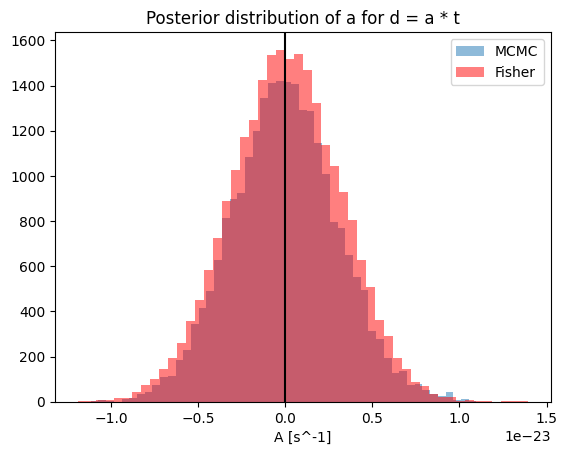

MCMC stdev on a: 3.0330007075030667e-24 s^-1
Fisher stdev on a: 3.186565396428416e-24 s^-1


In [ ]:
plt.title('Posterior distribution of a for d = a * t')
plt.hist(samples_rescaleda,alpha=0.5,bins=50,label='MCMC')
plt.hist(samples_fisha,color='r',alpha=0.5,bins=50,label='Fisher')
plt.axvline(x=myparsa[0],c='k')
plt.xlabel('A [s^-1]')
plt.legend()
plt.show()
print('MCMC stdev on a:',sigma_a,'s^-1')
print('Fisher stdev on a:',np.sqrt(1/Faafine),'s^-1')

The dark energy model is given by:

$$
d_{DE} = \frac{\sqrt{X}}{M_{\text{eff}}} t = \frac{\sqrt{(1+w) \cdot 0.5 \cdot \rho_{\text{DE}}}}{M_{\text{eff}}} t
$$

where:
- $\rho_{\text{DE}}$ is the energy density of Dark Energy.
- $M_{\text{eff}}$ is the effective mass
- w is reated to the equation of state and is equal to $ 1 - 2\beta $
- $ \beta = \frac{\phi'^2}{2V} = \frac{X}{V} $

Thus, we can express X as:

$$
X = \beta V = \frac{(1-w)V}{2} \implies \sqrt{X} = \sqrt{(1+w) \cdot 0.5 \cdot \rho_{\text{DE}}}
$$

Finally, the model is parameterized as:

$$
d = a \cdot t
$$

where a was sampled in the MCMC analysis above.

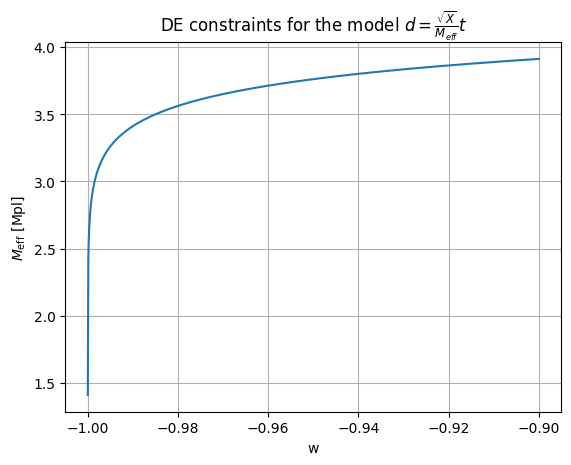

In [ ]:
####### PLOTTER DE ###########

'''

The model is d = [sqrt(X)/(M_eff)] * t = sqrt((1+w)*0.5*rhoDE) / Meff * t

where we used:
w=1-2beta
beta=phiprime^2/(2V)=X/V -> X=beta*V=(1-w)*V/2 -> sqrt(X)=sqrt((1+w)*0.5*rhoDE)

parametrized d = a * t


'''
# Constants:

rhoDE = (2.4e-3)**4 # energy density of Dark Energy in units of eV^4
hbar = 4.135667696e-15 /(2 * np.pi)
Mpl = 1.22e28 # Planck mass in eV
A0f = 2e-18
om0f = 1.99e-7

def Meff_of_w(w):
    ''' calculate the effective mass as a function of the parameter w '''
    return ((np.sqrt(((1 + w) / 2.) * rhoDE))/(sigma_a * hbar * np.pi * 2)) / Mpl

w_range = np.linspace(-0.999999,-0.9,1000)

# Calculate Meff for all clock pairs over the range of w and plot
plt.plot(w_range, np.log10(Meff_of_w(w_range)))

plt.title('DE constraints for the model '+r"$d=\frac{\sqrt{X}}{M_{eff}}t$")
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel(r"w")
plt.ylabel(r"$M_{\rm eff}$ [Mpl]")
#plt.legend(loc='lower right')
plt.grid()
plt.show()

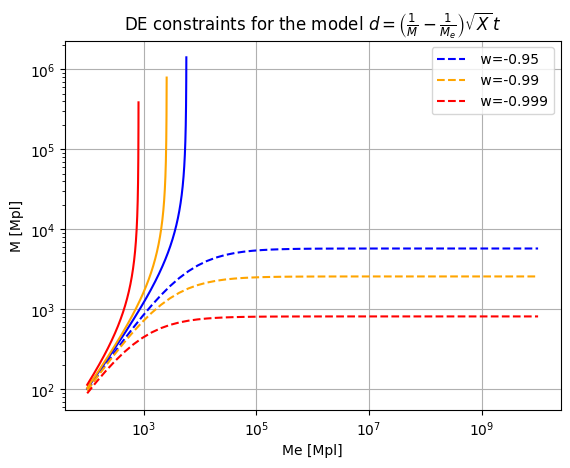

In [ ]:
####### PLOTTER DE1 ###########

rhoDE = (2.4e-3) ** 4
hbar = 4.135667696e-15 / (2 * np.pi)
Mpl = 1.22e28
A0f = 2e-18
om0f = 1.99e-7

# Define sigma_a and clock_pair_name for the single clock case
wss = [-0.95, -0.99, -0.999]
colorss = ['blue', 'orange', 'red']

def M_of_Me(Me, w):
    return ((sigma_a * hbar * np.pi * 2) / np.sqrt(((1. + w) / 2.) * rhoDE) + 1 / Me) ** (-1.)

def M_of_Me2(Me, w):
    return (-(sigma_a * hbar * np.pi * 2) / np.sqrt(((1. + w) / 2.) * rhoDE) + 1 / Me) ** (-1.)

Merange = np.logspace(2, 10) * Mpl

for i in range(len(wss)):
    Mecrit = np.sqrt(((1. + wss[i]) / 2.) * rhoDE) / (sigma_a * hbar * np.pi * 2)
    Merange2 = np.logspace(2, np.log10(Mecrit / Mpl), 1000, endpoint=False) * Mpl

    plt.loglog(Merange / Mpl, M_of_Me(Merange, wss[i]) / Mpl, label= ' w=' + str(wss[i]), color=colorss[i], linestyle='dashed')
    plt.loglog(Merange2 / Mpl, M_of_Me2(Merange2, wss[i]) / Mpl, color=colorss[i])

plt.title('DE constraints for the model ' + r"$d=\left(\frac{1}{M}-\frac{1}{M_e}\right)\sqrt{X}\,t$")
plt.xlabel(r"Me [Mpl]")
plt.ylabel(r"M [Mpl]")
plt.legend(loc='upper right')
plt.grid()
plt.show()